# Plot chl phenology

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#[Phenology-stats]" data-toc-modified-id="[Phenology-stats]-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>[Phenology stats]</a></span></li><li><span><a href="#[Plotting]" data-toc-modified-id="[Plotting]-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>[Plotting]</a></span></li></ul></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Mean-biome-climatology-timeseries" data-toc-modified-id="Mean-biome-climatology-timeseries-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Mean biome climatology timeseries</a></span></li><li><span><a href="#Biome-stats" data-toc-modified-id="Biome-stats-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Biome stats</a></span></li></ul></li><li><span><a href="#Plot-biome-climatological-seas-cycle-w-bloom" data-toc-modified-id="Plot-biome-climatological-seas-cycle-w-bloom-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot biome climatological seas cycle w bloom</a></span></li></ul></div>

In [1]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
import bp12_tools as bp12
import bp12_tools.plot_utils as pu

import pandas as pd
import numpy as np
import xarray as xr

from cartopy import crs as ccrs, feature as cfeature
from cmcrameri import cm
import cmocean.cm as cmo
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

---

## Functions

 ### [Phenology stats]

In [2]:
def get_phen_info_3d(filename):
    '''
    read phenology on map and convert to dates
    '''
    phen_mdl = xr.open_dataset(filename)
    mdl_init = phen_mdl.initiation_ts.astype('<M8[ns]').dt.dayofyear
    mdl_term = phen_mdl.termination_ts.astype('<M8[ns]').dt.dayofyear
    mdl_dura_arr = phen_mdl.duration_ts.values.astype('timedelta64[D]').astype('int')
    mdl_dura_arr =np.ma.masked_where(mdl_dura_arr<0,mdl_dura_arr)
    mdl_phen = xr.Dataset(
            data_vars={
                "init": (['lat','lon'], mdl_init.values),
                "term": (['lat','lon'], mdl_term.values),
                "dura": (['lat','lon'], mdl_dura_arr[:])
            },
            coords = {'lat': (['lat'], phen_mdl.lat.values),
              'lon': (['lon'], phen_mdl.lon.values)
             }
            )
    return mdl_phen

def get_phen_info(filename):
    '''
    read phenology from TS
    '''
    phen_mdl = xr.open_dataset(filename)
    mdl_init = phen_mdl.initiation_ts.values.astype('<M8[ns]') #.dt.dayofyear
    mdl_term = phen_mdl.termination_ts.values.astype('<M8[ns]')# .dt.dayofyear
    mdl_max = phen_mdl.max_time.values.astype('<M8[ns]')#.dt.dayofyear
    mdl_dura = phen_mdl.duration_ts.values.astype('timedelta64[D]').astype('int')
    return (mdl_init, mdl_term, mdl_max, mdl_dura)

def get_bp12_date(dayin, cal='365'):
    '''
    365 day calendar date
    '''
    #if cal in '365':
    dayin = int(dayin)
    ndays_in_mo = [0,31,28,31,30,31,30,31,31,30,31,30,31]
    cum_days = np.array([sum(ndays_in_mo[:i+1]) for i in range(len(ndays_in_mo))]) 
    m_indx = np.argmax(np.where(cum_days<dayin))
    mo_out = m_indx + 1
    day_out = dayin-cum_days[m_indx]+1
    # Adjust for plot that starts in July
    # if in 1st 6 months of yr, change yr
    if mo_out < 7:
        return pd.Timestamp(2001, mo_out, day_out)
    else:
        return pd.Timestamp(2000, mo_out, day_out)

    
def get_biome_itd(ds_in, biome):
    '''
    get biome initiation, termination and duration mean
    '''
    init_mean, init_std = get_bp12_date(int(ds_in[f'init{biome}_mean'].values)), int(ds_in[f'init{biome}_std'].values)
    term_mean, term_std = get_bp12_date(int(ds_in[f'term{biome}_mean'].values)), int(ds_in[f'term{biome}_std'].values)
    dura_mean, dura_std = int(ds_in[f'dura{biome}_mean'].values), int(ds_in[f'dura{biome}_std'].values)
    return (init_mean, init_std, term_mean, term_std, dura_mean, dura_std)    

### [Plotting]

In [3]:
def make_reorder_ds(mdlvals, obsvals):
    '''
    reorder jan-dec monthly to
    july to july monthly
    '''
    ts_jj = [pd.Timestamp(2000, mo, 1) for mo in range(7,13)]+[pd.Timestamp(2001, mo, 1) for mo in range(1,8)]
    mdl_new = np.concatenate((mdlvals.sel(time=slice('2000-07-01','2000-12-31')).values, 
                              mdlvals.sel(time=slice('2000-01-01','2000-07-31')).values))
    obs_new = np.concatenate((obsvals.sel(time=slice('2000-07-01','2000-12-31')).values, 
                              obsvals.sel(time=slice('2000-01-01','2000-07-31')).values))    
    ds_new = xr.Dataset(
        data_vars={
            "mdl": (['time'], mdl_new[:]),
            "obs": (['time'], obs_new[:])
            },
        coords = {'time': (['time'], ts_jj[:])
                 }
        )
    return ds_new    

In [5]:
red, blue = pu.formatting.get_rbg_colors('r'), pu.formatting.get_rbg_colors('b')

In [6]:
def plot_biomeclim(axin, mean_mdl, mean_obs, std_mdl, std_obs, colrin, bloomin=None, add_leg=None, add_leg_it=None, add_leg_max=None):
   
    mean_ds =make_reorder_ds(mean_mdl, mean_obs)
    std_ds =make_reorder_ds(std_mdl, std_obs)
    axin.plot(mean_ds.time, mean_ds.mdl, c=red, lw=2, label='BIOPERIANT12')
    #axin.fill_between(mean_ds.time, mean_ds.mdl-std_ds.mdl, mean_ds.mdl+std_ds.mdl, 
    #                                   alpha=0.25, zorder=20, facecolor=red)
    axin.plot(mean_ds.time, mean_ds.obs, c=blue, lw=2,  label='OBS')
    #axin.fill_between(mean_ds.time, mean_ds.obs-std_ds.obs, mean_ds.obs+std_ds.obs, 
    #                                   alpha=0.25, zorder=20, facecolor=blue)
    axin.set_xlim(pd.Timestamp(2000, 7, 1), pd.Timestamp(2001, 7, 2))
    axin.xaxis.set_ticks(mean_ds.time)
    axin.xaxis.set_ticklabels(['J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J','J'],
                           fontsize=12)
    axin.set_xlabel("Month of year")
    axin.set_ylim(0, 2)
    axin.set_ylabel(chl_cbar, labelpad=5, fontsize=12)
    axin.grid(lw=1, c='0.75', alpha=0.4)
    #pu.timeseries_plots.add_seas(axin, (0, 1.9), True)
    
    if bloomin:
        tpad = pd.Timedelta('10 days')
        init_m, term_m, max_m, dura_m = bloomin[0], bloomin[1], bloomin[2], bloomin[3]
        init_o, term_o, max_o, dura_o = bloomin[4], bloomin[5], bloomin[6], bloomin[7]
        yinit_m, yterm_m = mean_ds.mdl.interp(time=init_m).values, mean_ds.mdl.interp(time=term_m).values
        yinit_o, yterm_o = mean_ds.obs.interp(time=init_o).values, mean_ds.obs.interp(time=term_o).values
        ymax_m,  ymax_o  = mean_ds.mdl.interp(time=max_m).values, mean_ds.obs.interp(time=max_o).values
    
        #print(init_o, yinit_o)
        # draw init and term circles
        circr=8
        plt.plot(init_m, yinit_m, "o", ms=circr, mec=red, mfc='none', mew=1)
        plt.plot(term_m, yterm_m, "o", ms=circr, mec=red, mfc=red, mew=1)
        plt.plot(init_o, yinit_o, "o", ms=circr, mec=blue, mfc='none', mew=1)
        plt.plot(term_o, yterm_o, "o", ms=circr, mec=blue, mfc=blue, mew=1)
        
        # model duration
        plt.annotate('', xy=(init_m,1.2), xycoords='data', xytext=(term_m,1.2), textcoords='data', color=red,
                     arrowprops={'arrowstyle': '<->', 'ls':'--', 'lw': 1, 'color': '#0063c5'})
        x_txtpos = init_m + np.timedelta64(int(dura_m/2)-60, 'D')
        plt.annotate(f'{dura_m} days', xy=(x_txtpos, 1.25), xycoords='data', color=red)
        # obs duration
        plt.annotate('', xy=(init_o,0.05), xycoords='data', xytext=(term_o,0.05), textcoords='data', color=blue,
                     arrowprops={'arrowstyle': '<->','ls':'--', 'lw': 1, 'color': blue})
        x_txtpos = init_o + np.timedelta64(int(dura_o/2)-55, 'D')
        plt.annotate(f'{dura_o} days', xy=(x_txtpos, 0.1), xycoords='data', color=blue)
    
    if add_leg:
        #axin.legend(ncol=1, frameon=False)
        line_mdl = mpl.lines.Line2D([], [], color=red, lw=2, label='BIOPERIANT12')
        line_obs = mpl.lines.Line2D([], [], color=blue, lw=2, label='OBS') #linestyle='--',
        leg1 = axin.legend(handles = [line_mdl, line_obs], ncol=1, fontsize=10, 
                      bbox_to_anchor=(-0.02, 0.65), loc="lower left",frameon=False)
        axin.add_artist(leg1)
    if add_leg_it:
        circ_i = mpl.lines.Line2D([], [], color='k', label='Bloom initiation',  marker='o', mfc='none', linestyle='None', markersize=8)
        circ_t = mpl.lines.Line2D([], [], color='k', label='Bloom termination', marker='o', linestyle='None', markersize=8)       
        leg2 = axin.legend(handles=[circ_i, circ_t], fontsize=10,
                    bbox_to_anchor=(-0.02, 0.65), loc="lower left",frameon=False)
        axin.add_artist(leg2)
    if add_leg_max:
        plt.plot(max_m, ymax_m, "d", ms=circr, mec=red, mfc=red, mew=1)
        plt.plot(max_o, ymax_o, "d", ms=circr, mec=blue, mfc=blue, mew=1)
        dia_max = mpl.lines.Line2D([], [], color='k', label='Bloom max', marker='d', linestyle='None', markersize=8)
        leg3 = axin.legend(handles=[dia_max], fontsize=10,
                    bbox_to_anchor=(-0.04, 0.78), loc="lower left",frameon=False)
        axin.add_artist(leg3)
    axin.set_rasterized(True)
    

## Load Data

In [7]:
unitstr = pu.formatting.get_unit_mplstr(bp12.model_utils.get_varinfo('chl','unit'))
chl_title = f"{bp12.model_utils.get_varinfo('chl','long_name')} {unitstr}"
chl_cbar = f"Chl {unitstr}"

**OBS OC-CCI v6 biome filtered**  
biome15: 0.358 +- 0.130  
biome16: 0.355 +- 0.152  
biome17: 0.213 +- 0.199  

### Mean biome climatology timeseries

In [8]:
chl_bts_mdl = xr.open_dataset(f"../data/TIMESERIES/BIOPERIANT12_timeseries_chl_meanbiome_clim.nc")
chl_bts_obs = xr.open_dataset(f"../data/TIMESERIES/OBS_timeseries_chl_meanbiome_clim.nc")

### Biome stats

In [9]:
b15_phen_obs = get_phen_info(f"../data/CHL/OCCCIv6_PHENOLOGY_biome15_clim.nc")
b16_phen_obs = get_phen_info(f"../data/CHL/OCCCIv6_PHENOLOGY_biome16_clim.nc")
b17_phen_obs = get_phen_info(f"../data/CHL/OCCCIv6_PHENOLOGY_biome17_clim.nc")
b15_phen_mdl = get_phen_info(f"../data/CHL/BIOPERIANT12_PHENOLOGY_biome15_clim.nc")
b16_phen_mdl = get_phen_info(f"../data/CHL/BIOPERIANT12_PHENOLOGY_biome16_clim.nc")
b17_phen_mdl = get_phen_info(f"../data/CHL/BIOPERIANT12_PHENOLOGY_biome17_clim.nc")

## Plot biome climatological seas cycle w bloom

In [11]:
color17 = pu.formatting.get_biome_colors(17)
color16 = pu.formatting.get_biome_colors(16)
color15 = pu.formatting.get_biome_colors(15)

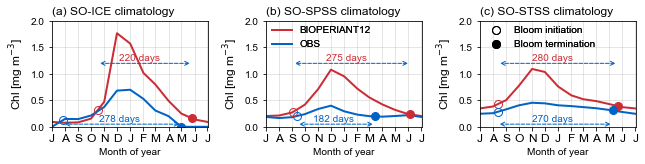

In [12]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(241)
z_ts=0
plot_biomeclim(ax1, chl_bts_mdl.chl17_mean.sel(deptht=z_ts, method='nearest'), chl_bts_obs.chl17_mean, 
               chl_bts_mdl.chl17_std.sel(deptht=z_ts, method='nearest'), chl_bts_obs.chl17_std,
               color17, 
               (b17_phen_mdl[0], b17_phen_mdl[1], b17_phen_mdl[2], b17_phen_mdl[3], \
                b17_phen_obs[0], b17_phen_obs[1], b17_phen_obs[2], b17_phen_obs[3])) #, add_leg_max=True)
plt.title(f'(a) SO-ICE climatology',loc='left',fontsize=12)

ax2 = fig.add_subplot(242)
plot_biomeclim(ax2, chl_bts_mdl.chl16_mean.sel(deptht=z_ts, method='nearest'), chl_bts_obs.chl16_mean, 
               chl_bts_mdl.chl16_std.sel(deptht=z_ts, method='nearest'), chl_bts_obs.chl16_std,   
               color16,
              (b16_phen_mdl[0], b16_phen_mdl[1], b16_phen_mdl[2], b16_phen_mdl[3],\
               b16_phen_obs[0], b16_phen_obs[1], b16_phen_obs[2], b16_phen_obs[3]), add_leg=True)
plt.title(f'(b) SO-SPSS climatology',loc='left',fontsize=12)

ax3 = fig.add_subplot(243)
plot_biomeclim(ax3, chl_bts_mdl.chl15_mean.sel(deptht=z_ts, method='nearest'), chl_bts_obs.chl15_mean,
               chl_bts_mdl.chl15_std.sel(deptht=z_ts, method='nearest'), chl_bts_obs.chl15_std,
               color15,
              (b15_phen_mdl[0], b15_phen_mdl[1], b15_phen_mdl[2], b15_phen_mdl[3],\
               b15_phen_obs[0], b15_phen_obs[1], b15_phen_obs[2], b15_phen_obs[3]), add_leg_it=True)
       
plt.title(f'(c) SO-STSS climatology',loc='left',fontsize=12)
plt.tight_layout()
plt.savefig(f'../figures/f13.png', bbox_inches='tight')

In [13]:
print("bloom init")
print(f"biome 17 mdl={b17_phen_mdl[0]}, obs={b17_phen_obs[0]}")
print(f"biome 16 mdl={b16_phen_mdl[0]}, obs={b16_phen_obs[0]}")
print(f"biome 15 mdl={b15_phen_mdl[0]}, obs={b15_phen_obs[0]}")

bloom init
biome 17 mdl=2000-10-17T12:00:00.000000000, obs=2000-07-27T00:00:00.000000000
biome 16 mdl=2000-09-02T12:00:00.000000000, obs=2000-09-13T00:00:00.000000000
biome 15 mdl=2000-08-13T12:00:00.000000000, obs=2000-08-12T00:00:00.000000000


In [14]:
print("bloom term")
print(f"biome 17 mdl={b17_phen_mdl[1]}, obs={b17_phen_obs[1]}")
print(f"biome 16 mdl={b16_phen_mdl[1]}, obs={b16_phen_obs[1]}")
print(f"biome 15 mdl={b15_phen_mdl[1]}, obs={b15_phen_obs[1]}")

bloom term
biome 17 mdl=2001-05-25T12:00:00.000000000, obs=2001-05-01T00:00:00.000000000
biome 16 mdl=2001-06-04T12:00:00.000000000, obs=2001-03-14T00:00:00.000000000
biome 15 mdl=2001-05-20T12:00:00.000000000, obs=2001-05-09T00:00:00.000000000


In [15]:
print("bloom max")
print(f"biome 17 mdl={b17_phen_mdl[2]}, obs={b17_phen_obs[2]}")
print(f"biome 16 mdl={b16_phen_mdl[2]}, obs={b16_phen_obs[2]}")
print(f"biome 15 mdl={b15_phen_mdl[2]}, obs={b15_phen_obs[2]}")

bloom max
biome 17 mdl=2000-12-26T12:00:00.000000000, obs=2000-12-26T00:00:00.000000000
biome 16 mdl=2000-12-26T12:00:00.000000000, obs=2000-12-10T00:00:00.000000000
biome 15 mdl=2000-12-01T12:00:00.000000000, obs=2000-11-24T00:00:00.000000000
